# LABORATORY OF COMPUTATIONAL PHYSICS (MOD. B) 
## Assigment 2: RBMS
### GROUP 4
##### Authors
- Qiqi Zhang 2072838
- David Altamirano 2081255
- Stefano Meza 2070772
- Francisco Pasian 2078684

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import NullFormatter
import itertools
plt.rcParams['font.size'] = 14

!mkdir Dataw
!mkdir DATA_c_txts





mkdir: cannot create directory ‘Dataw’: File exists
mkdir: cannot create directory ‘DATA_c_txts’: File exists


**Load data**

In [2]:
#Choose data to be used
CASE=2
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"
if CASE==2: dname="DATAC"

#Load rows in v vector
fname=dname+'/x_RBM_q0.2.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])


#COnvert input data to 0,1 or 1-1

#SPINS = True  #-1 and 1 
SPINS = False  # 0 and 1


def change(SPINS,v):
    if SPINS:
        # sigmoid takes into account energy difference =2
        GAP=2
        v = 2*v - 1
        vmin=-1
    else:
        GAP=1
        vmin=0
    return v, GAP, vmin
    

print("Number of rows: {}".format(N))

def storage_data(likehood, w, a, b, optimizer, cd_loops, epoch, centering_trick, SPINS):

    if centering_trick == True:
        centering_trick = "_ct"
    else: 
        centering_trick = ""

    if SPINS == True:
        SPINS = "11"
    else: 
        SPINS = "01"

    

    np.savetxt('DATA_c_txts/DATAc_'+str(epoch)+"_likehood_"+str(optimizer)+'_cd'+str(cd_loops)+str(centering_trick)+str(SPINS)+".dat",likehood)
    np.savetxt('DATA_c_txts/DATAc_'+str(epoch)+"_w_"+str(optimizer)+'_cd'+str(cd_loops)+str(centering_trick)+str(SPINS)+".dat",w)
    np.savetxt('DATA_c_txts/DATAc_'+str(epoch)+"_a_"+str(optimizer)+'_cd'+str(cd_loops)+str(centering_trick)+str(SPINS)+".dat",a)
    np.savetxt('DATA_c_txts/DATAc_'+str(epoch)+"_b_"+str(optimizer)+'_cd'+str(cd_loops)+str(centering_trick)+str(SPINS)+".dat",b)

    return()

v, GAP, vmin = change(SPINS,v)
print(v[0], GAP, vmin)


Number of rows: 10000
[0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0] 1 0


**Initialize parameters**

In [3]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
if CASE==2: M = 2

# range of each initial weight
sigma = sqrt(4. / float(L + M))


# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

print("Number of hidden units: {}".format(M))

Number of hidden units: 2


**Plotting**

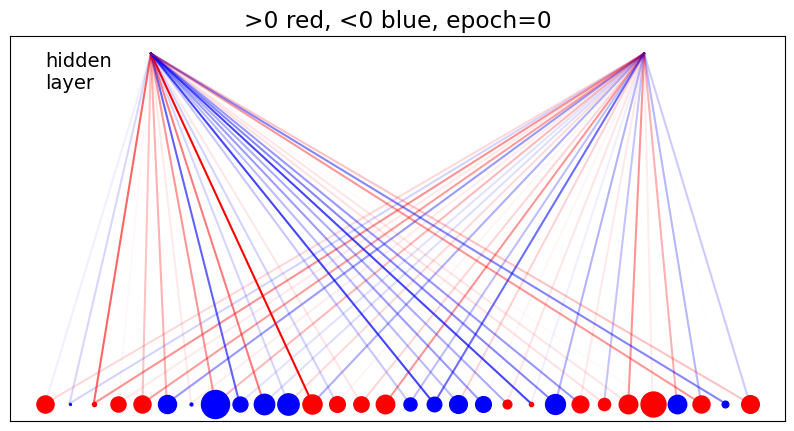

In [26]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    #print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(w,epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(w,a,b, epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()

def heatmap_plot(bias,weight,A=6,G=5):
    fig, axs = plt.subplots(1, 3)

    im = axs[0].imshow(bias.reshape((A,G)), cmap='RdYlBu_r', aspect='auto')
    fig.colorbar(im)
    axs[0].set_xticks([0,1,2,3,4,5])
    axs[0].set_title('Bias')

    for j in range(0,weight.shape[1]):
        im = axs[j+1].imshow(weight[:,j].reshape((A,G)), cmap='RdYlBu_r', aspect='auto')
        fig.colorbar(im)
        axs[j+1].set_xticks([0,1,2,3,4,5])
        axs[j+1].set_title('Group {}'.format(j+1))

    #im = axs[2].imshow(weight[:,1].reshape((A,G)), cmap='RdYlBu_r', aspect='auto')
    #fig.colorbar(im)
    #plt.xticks([0,1,2,3,4,5])
    #axs[2].set_title('Group 2')


    fig.tight_layout()
    fig.suptitle('Weights')
    fig.subplots_adjust(top=0.85)

plotgraph(w,a,b)
                  

**Activation function**

In [5]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print("wei= ", wei)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

def new_activate(h_in,v_in,wei,bias,DE,A,info=False):
    """
    -- Parameters --
    h_in : result of positive CD phase
    v_in : visible matrix input
    wei: weights
    bias: bias
    DE: it's the GAP, distance btw [0,1] or [-1,1]
    A: block of bits/states
    info: print some results
    
    -- Returns --
    v_out : vector of shape n, keeps the one-hot encoding
    """
    
    # Create a matrix to store energy values
    store_energy = np.zeros(A)
    
    # Split columns in blocks of A bits
    for i in range(0,wei.shape[1],A):
        v_in_a = v_in[i:A+i]
        #print('visible layer',v_in_a,v_in_a.shape)
        wei_a = wei[:,i:A+i]
        #print('shape w.T',wei_a.shape)
        bias_a = bias[i:A+i]
        act = np.dot(h_in, wei_a) + bias_a # phi
        n = np.shape(act)
        #print('n-act',n)
        
        # Determine i-th energy per block
        idx = np.argmax(v_in_a) 
        #print(idx)
        E = np.dot(act,v_in_a) # it's the E_i energy
        #print(E)
        store_energy[idx] += E
        #print(store_energy)

    # Determine probability
    # B_gamma - B_i= e^E_i
    B = np.exp(store_energy)
    #print('B::',B,np.sum(B))
    # probability of each state energy - normalize
    prob = B / np.sum(B)
    #print(prob, np.sum(prob))

    #if np.sum(prob)!=1.:
    #    print('Error: The sum of the probability is NOT 1 \n', np.sum(prob))

    # Concatenate output vector
    v_output = np.array([])
    
    for i in range(0,wei.shape[1],A):
        idx_choice = np.random.choice(A, p=prob)
        #print('choice',idx_choice)
        v_out = np.full(A, vmin, dtype=int) # a list on -1's or 0's (vmin)     --np.full(n, vmin, dtype=int)
        v_out[idx_choice] = 1 # activate the 1's with probability prob
        #print('out-choice',v_out)
        v_output = np.concatenate((v_output,v_out))
    
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_output)
        print('final',store_energy)

    return v_output

**Optimizers**

In [6]:
def adam_optimizer(moment_1, moment_2, beta, w, a, b, count, epsilon,l_rate):     
    dparam=[w,a,b]
    moment_1h=[0,0,0]
    moment_2h=[0,0,0]
    for i in range(3):           
        moment_1[i]= beta[0]*moment_1[i] + (1-beta[0])*dparam[i]            
        moment_2[i]= beta[1]*moment_2[i]+(1-beta[1])*dparam[i]**2
        moment_1h[i]= moment_1[i]/(1-beta[0]**count)
        moment_2h[i] = moment_2[i]/(1-beta[1]**count)     
        dparam[i] = +l_rate*moment_1h[i]/(np.sqrt(moment_2h[i]) + epsilon ) 

    return(dparam[0],dparam[1],dparam[2], moment_1, moment_2)


def RMSprop(dw,da,db, momentum_w, momentum_a, momentum_b, beta, eps, l_rate_rms):

    momentum_w = beta*momentum_w + (1-beta)*dw**2
    momentum_a = beta*momentum_a + (1-beta)*da**2
    momentum_b = beta*momentum_b + (1-beta)*db**2
    dw =  l_rate_rms*(dw/np.sqrt(momentum_w + eps))
    da =  l_rate_rms*(da/np.sqrt(momentum_a + eps))
    db =  l_rate_rms*(db/np.sqrt(momentum_b + eps))

    return dw, da, db, momentum_w, momentum_a, momentum_b

**Permutation of hidden and visible units**

In [7]:
def Vcombination(n):
    A = []
    for i in range(n):
        A.append([1 if j == i else 0 for j in range(n)])
    return A

#Generate all posible permutations with repetitions for vissible and hidden units
def permutation_txt(A,G,fname):
    P=[]
    for p in itertools.product(A, repeat=G):
        b=[]
        for i in range(G):
            b = b + p[i]
        P.append(b)
    np.savetxt(str(fname)+'.dat',np.asarray(P).astype(int),delimiter=" ",fmt="%d")
    return(np.asarray(P))

visible_layer = permutation_txt(Vcombination(6), 5, "visible")
hidden_layer = permutation_txt([[0],[1]], len(Vcombination(2)), "hidden" )

**Energies and Probs**

In [8]:

#partition function
def energy(w,a,b,vp,hp):
    term_a=0
    term_b=0
    term_c=0
    total = 0
    PROB=[]
    for i in hp:
        for j in vp:
            a_0=np.matmul(j,w)
            
            term_a= np.matmul(a_0, i)
   
  
            term_b = np.matmul(a,j)

    
            term_c = np.matmul( b.reshape(1,len(i)), i)
            
            prob = np.exp(term_a+term_b+term_c)
            PROB.append(prob)
            total = total + prob



    return(total, PROB)



def first_term_ll(vd, hp, w, a, b):
    M=len(vd)
    total=0
    total1=0
    for j in vd:
        for i in hp:
            a_0=np.matmul(j,w)
            
            term_a= np.matmul(a_0, i)
   
  
            term_b = np.matmul(a,j)

    
            term_c = np.matmul( b.reshape(1,len(i)), i)

            prob = np.exp(term_a+term_b+term_c)
            total = total + prob
        total1 = total1 + np.log(total)
        total = 0
    
    return(total1/M)

**RBM backbone**

In [9]:
np.random.seed(12345)

def restricted_boltzman_machine(x, optimizer, cd_loops, visible, hidden ,v , backwards= False, printing=False,centering_trick=False, w=w, a=a, b=b, SPINS=False,store =False):
    v, GAP, vmin = change(SPINS, v)
    visible, nel, nel = change(SPINS, visible)
    hidden, nel, nel =change(SPINS,hidden)
    #Global parameters
    mini, m = 500, 0
    l_rate = 1.0  
    likehood = []
    #VanillaSGD



    #Adam parameters
    betas = 0.9, 0.99
    moment_1 = [0.0, 0.0, 0.0]
    moment_2 = [0.0, 0.0, 0.0]
    epsilon = 1*10**-8
    count = 1

    #RMSprop parameters
    momentum_w= momentum_a = momentum_b = 0
    l_rate_sgd = 10**(-3)
    beta=0.9
    eps = 10**(-8)

    #Centering trick parameters

    etha_lambda= 0.01
    etha_mu = 0.01
    mu = 0
    lam = 0

    #Backwards parameters
    A = 6

    
    for epoch in range(x):
        l_rate_m = l_rate / mini
        for k in range(N):
            #load zero arrays
            if m==0:
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))


            #Contrastive divergence

            h = activate(v[k],w,b,GAP)
            h_data  += h
            v_data  += v[k]
            #h1= np.copy(h)

            for cd in range(cd_loops):
                #vf = activate(h,w.T,a,GAP)
                if backwards == True:
                    vf = new_activate(h,v[k],w.T,a,GAP,A,False)
                else:   
                    vf = activate(h,w.T,a,GAP)
                hf = activate(vf,w,b,GAP)
                h = hf
                
            h = activate(v[k],w,b,GAP)
            
            v_model += vf
            
            h_model += hf
            

            vh_model+= np.matmul(vf.reshape(len(v[1]),1), hf.reshape(1, len(h)))
            vh_data += np.matmul(v[k].reshape(len(v[1]),1), h.reshape(1, len(h)))
            
        




            m+=1

            if m==mini:


                # algorithm 4 of the pdf "LCP_2023_exercise2"
                if centering_trick == True:
                    mu_batch=v_data
                    lam_batch = h_data
                    #a = a + etha_lambda*np.matmul(w,(lam_batch-lam))
                    #b = b + etha_mu*np.matmul(w.T,(mu_batch-mu))
                    mu = (1-etha_mu)*mu +etha_mu*mu_batch
                    lam= (1-etha_lambda)*lam + etha_lambda*lam_batch

                    dw = np.outer((v_data-mu),(h_data-lam).T) - np.outer((v_model-mu),(h_model-lam).T) 
                    da = v_data - v_model - np.matmul(dw, lam)
                    db = h_data - h_model - np.matmul(dw.T, mu)

            
                else: 
                    dw = (vh_data - vh_model)
                    da = (v_data - v_model)
                    db = (h_data - h_model)



                #Choose optimizer

                if optimizer == "VanillaSGD":
                    # gradient of the likelihood: follow it along its positive direction
                    # with a "vanilla" SGD
                    # basic step of vanilla gradient descent, from eq.(211)
                    dw=l_rate_m*dw
                    da=l_rate_m*da
                    db=l_rate_m*db
                    
                elif optimizer == "adam":

                    dw, da, db, moment_1, moment_2 = adam_optimizer(moment_1, moment_2, betas, dw, da, db, count, epsilon, l_rate_sgd)
                    count = count +1
         
                elif optimizer == "RMSprop":

                    dw, da, db, momentum_w, momentum_a, momentum_b = RMSprop( dw,da,db, momentum_w, momentum_a, momentum_b, beta, eps, l_rate_sgd)
                    
                    

                w = w + dw
                a = a + da
                b = b + db

                m=0




                    
        # decrease the learning rate (here as a power law)
        np.random.shuffle(v)
        l_rate = l_rate / (0.01 * l_rate + 1)
    
        if epoch%10==9 and printing==True: 
            plotgraph(w,a,b, epoch+1)
            print('l_rate = ',l_rate)

        second_term=energy(w,a,b,visible, hidden)
        first_term=first_term_ll(v, hidden, w, a, b)
        total_term = first_term - np.log(second_term[0])
        likehood.append(total_term)
    if store==True:
        storage_data(likehood, w, a, b, optimizer, cd_loops, epoch+1, centering_trick, SPINS)
        return(likehood, w, a, b, )
    else:
        return(likehood, w, a, b, )



**Call function Restricted Boltzman Machine**

For all the test, we created a function that is able to execute each configuration and save the results in .dat files. 

In [ ]:
"""test_1 = restricted_boltzman_machine(epoch, "optimizer", cd_loops,
                                        visible_layer_combination, hidden_layer_combination ,v_Data , backwards= False/True, 
                                        printing=True/False, centering_trick=False, SPINS=False, store =True)"""

#Where 100 is the number of epochs, "VanillaSGD" is optm

### 1) Use bits [0,1] or [-1,1]. Is reading weights easier in one of the two cases?

We decided to use a histogram of the weights for the final step so we can see clearly the distribution. For 0,1 we found the best result.
All values are distributed in 3 sharp lines.

Text(0.02, 0.5, 'Counts')

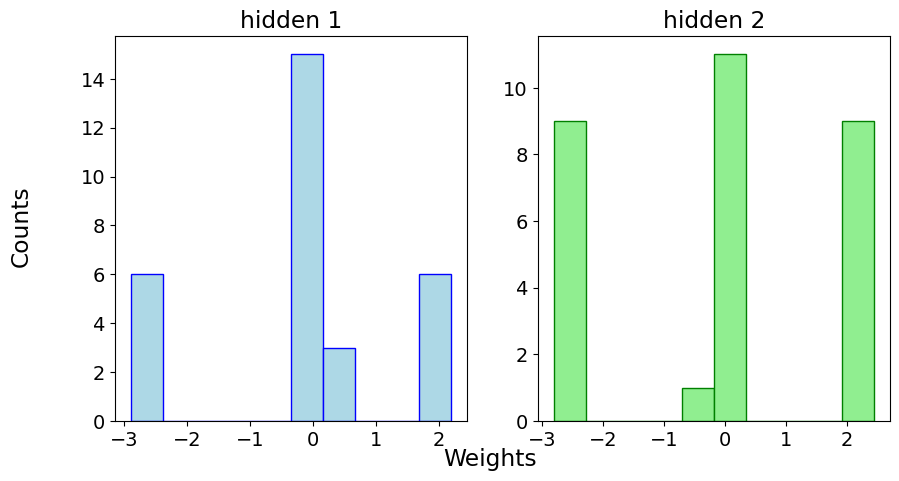

In [228]:
#Load weights for vanillaSGD at epoch=100
weights=np.loadtxt("DATA_c_txts/DATAc_100_w_VanillaSGD_cd101.dat")
fig, axis = plt.subplots(1, 2, figsize=(10,5))

axis[0].hist(weights[:,0], color = "lightblue", ec="blue")
axis[0].set_title("hidden 1")

axis[1].hist(weights[:,1], color = "lightgreen", ec="green")
axis[1].set_title("hidden 2")


fig.supxlabel("Weights")
fig.supylabel("Counts")


### 2) Implement an Adam or RMSprop gradient descent algorithm in the RBM notebook.

Adam and RMSprop optimizers show poor accuracy with respect to VanillaSGD. Nevertheless, RMSprop

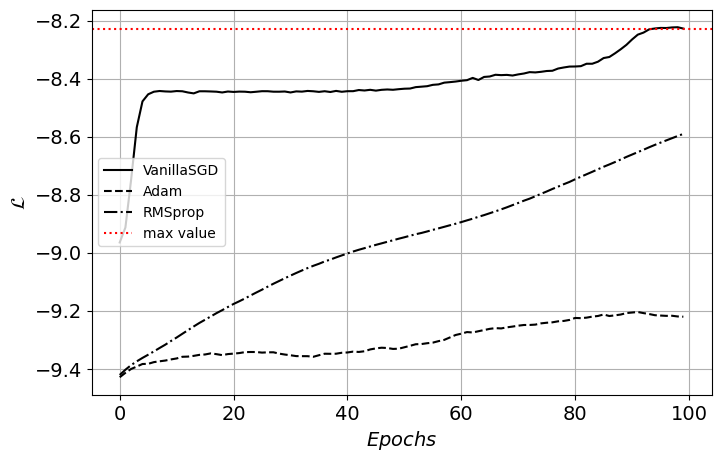

In [17]:
#Load likelihoods from different optimizers
likelihoodvanilla=np.loadtxt("DATA_c_txts/DATAc_100_likehood_VanillaSGD_cd101.dat")
likelihoodadam=np.loadtxt("DATA_c_txts/DATAc_100_likehood_adam_cd101.dat")
likelihoodrmsprop=np.loadtxt("DATA_c_txts/DATAc_100_likehood_RMSprop_cd101.dat")

fig, axis = plt.subplots(1,1, figsize=(8,5))
axis.plot(likelihoodvanilla, label="VanillaSGD", color="black")
axis.plot(likelihoodadam, label="Adam", color="black",  linestyle="dashed")
axis.plot(likelihoodrmsprop, label="RMSprop", color="black",  linestyle="dashdot")
axis.axhline(y = likelihoodvanilla[99], color="red", linestyle="dotted", label="max value")
axis.legend(fontsize="10")
#axis.set_title("Optimizers accuracy")
axis.set_xlabel(r"$Epochs$")
axis.set_ylabel(r"$\mathcal{L}$")
axis.grid()


### 3) Implement a backward step of contrastive divergence that preserves the one-hot encoding structure, thus generating one of A states in a block rather than one of 2A possible states. One randomly picks a block of A bits with probability proportional to the Boltzmann weight of its one-hot encoding, given the state of hidden units, the weights, and the local biases in that block.

New activation function for backwards step was implemented in Activation Function Section

In [21]:
#vmodel generated using backwards implementation
vmodel_vanillaCD1_bw=np.loadtxt("DATA_c_txts/DATAc_100_vmodel_VanillaSGD_cd101_bw.dat")
vmodel_bw=pd.DataFrame(vmodel_vanillaCD1_bw).astype(int)
#vmodel_bw.head()

print('With backwards implementation')

N1=10
df=vmodel_bw[:N1]
t=[i for i in range(N1)]
g = pd.Categorical(df[t]).codes # convert groups to indices  
df.style.apply(
    lambda x: ['background-color: {}'.format("#FFCCCC") for i in g], 
    subset=[0,1,2,3,4,5, 12,13,14,15,16,17, 24,25,26,27,28,29 ]
)

With backwards implementation


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
7,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
9,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [22]:
## without backward step
vmodel_vanillaCD1=np.loadtxt("DATA_c_txts/DATAc_100_vmodel_VanillaSGD_cd101.dat")
vmodel_=pd.DataFrame(vmodel_vanillaCD1).astype(int)
#vmodel_bw.head()

print('Without backwards implementation')

N1=10
df=vmodel_[:N1]
t=[i for i in range(N1)]
g = pd.Categorical(df[t]).codes # convert groups to indices  
df.style.apply(
    lambda x: ['background-color: {}'.format("#FFCCCC") for i in g], 
    subset=[0,1,2,3,4,5, 12,13,14,15,16,17, 24,25,26,27,28,29 ]
)

Without backwards implementation


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
9,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1


As can be seen, the results using a backward step preserves the one-hot encoding.

RMSProp: -9.208747591742117 98
Adam: -9.204441662350554 91


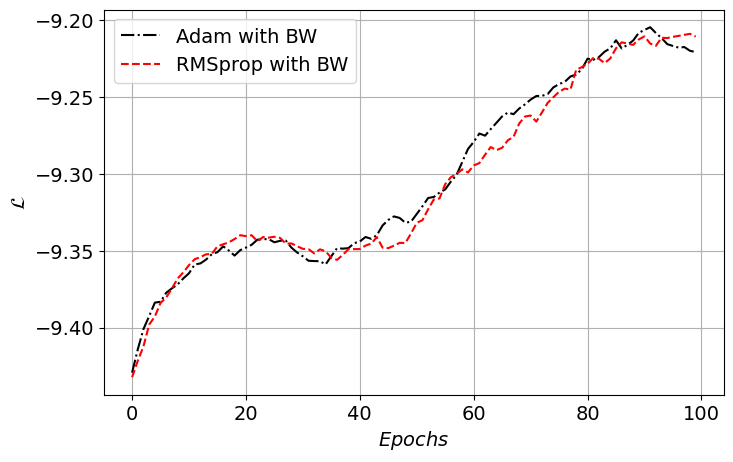

In [50]:
likelihoodAdamCD1=np.loadtxt("DATA_c_txts/DATAc_100_likehood_adam_cd101da.dat")
likelihoodRMSCD1=np.loadtxt("DATA_c_txts/DATAc_100_likehood_RMSprop_cd101da.dat")
likelihoodVanillaSGDCD1=np.loadtxt("DATA_c_txts/tefo.dat")
fig, axis = plt.subplots(1,1, figsize=(8,5))
axis.set_xlabel(r"$Epochs$")
axis.set_ylabel(r"$\mathcal{L}$")
axis.plot(likelihoodAdamCD1, label=r"Adam with BW", color="black", linestyle="dashdot")
axis.plot(likelihoodRMSCD1, label="RMSprop with BW", color="red",  linestyle="dashed")
#axis.plot(likelihoodVanillaSGDCD1[:3], label="VanillaSGD with BW", color="red",  linestyle="dashed")
axis.grid()
plt.legend()

#np.max(likelihoodAdamCD1)
#np.argmax(np.max(likelihoodAdamCD1))

print('RMSProp:',max(likelihoodRMSCD1),np.argmax(likelihoodRMSCD1))
print('Adam:',max(likelihoodAdamCD1),np.argmax(likelihoodAdamCD1))
#print('Adam with CT:',max(bw_likelihood_Adam),np.argmax(bw_likelihood_Adam))

### 4) Increase the number of contrastive divergence steps.

The highest accuracy was obtained by setting cd=2

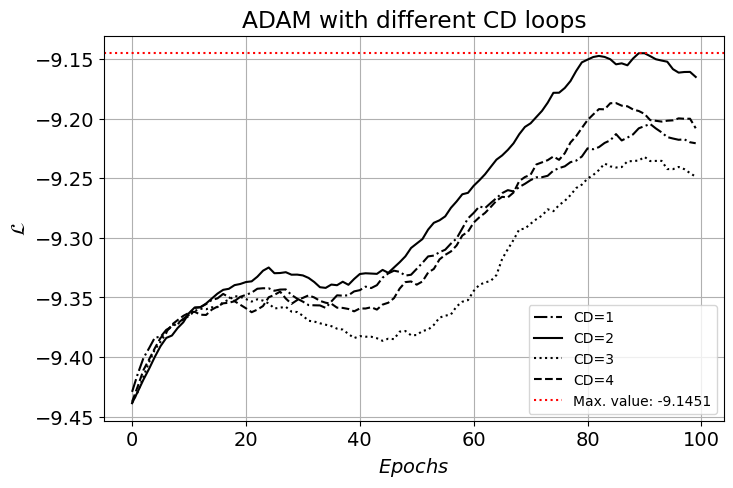

In [28]:
ikelihoodAdamCD1=np.loadtxt("DATA_c_txts/DATAc_100_likehood_adam_cd101.dat")
likelihoodAdamCD2=np.loadtxt("DATA_c_txts/DATAc_100_likehood_adam_cd201.dat")
likelihoodAdamCD3=np.loadtxt("DATA_c_txts/DATAc_100_likehood_adam_cd301.dat")
likelihoodAdamCD4=np.loadtxt("DATA_c_txts/DATAc_100_likehood_adam_cd401.dat")
likelihoodRMSCD1=np.loadtxt("DATA_c_txts/DATAc_100_likehood_RMSprop_cd101.dat")

fig, axis = plt.subplots(1,1, figsize=(8,5))
axis.plot(likelihoodAdamCD1, label="CD=1", color="black", linestyle="dashdot")
axis.plot(likelihoodAdamCD2, label="CD=2", color="black", linestyle="solid")
axis.plot(likelihoodAdamCD3, label="CD=3", color="black", linestyle=":")
axis.plot(likelihoodAdamCD4, label="CD=4", color="black", linestyle="dashed")

axis.axhline(y = max(likelihoodAdamCD2), color="red", linestyle="dotted", label="Max. value: {}".format(round(max(likelihoodAdamCD2), 4)))
axis.legend(fontsize="10")
axis.set_title("ADAM with different CD loops")
axis.set_xlabel(r"$Epochs$")
axis.set_ylabel(r"$\mathcal{L}$")#r'$L$')
axis.grid()

### 5) Plot the weights wiμ of each hidden unit μ in an A×G table (as in the example on the right), with a color map preserving the rule that red means positive and blue means negative weight.

We show the color map for the best combination which is Adam with backwards and cd=2

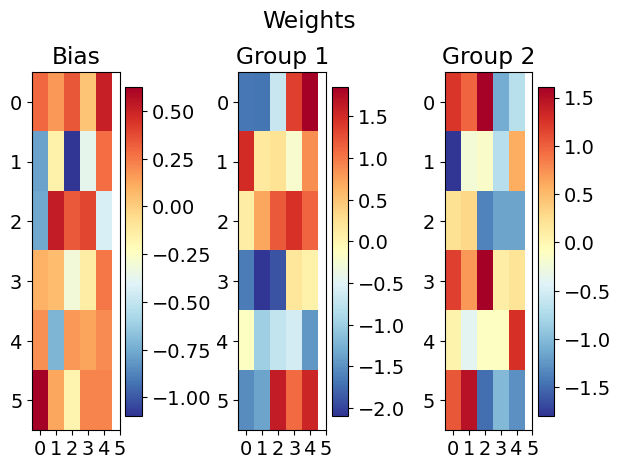

In [30]:
wvanillaCD1=np.loadtxt("DATA_c_txts/DATAc_100_w_adam_cd201.dat")
avanillaCD1=np.loadtxt("DATA_c_txts/DATAc_100_a_adam_cd201.dat")
heatmap_plot(avanillaCD1, wvanillaCD1)

### 6) Implement the "centering trick" described in the following pages, taken from Matteo Bortoletto's master thesis (note that different symbols for biases: a→b, b→c).

For this analysis we used 200 epochs for the adam optimizer, with cd=2 with and without centering trick. We can see it is possible to obtain a stable ressult by applying the centering trick.

array([-9.46719842, -9.46739886, -9.46685429, -9.46730881, -9.4669056 ,
       -9.46674201, -9.46665311, -9.46607931, -9.46585588, -9.46611261,
       -9.46635458, -9.46654476, -9.46604184, -9.46590861, -9.4650696 ,
       -9.46475964, -9.46417213, -9.46376937, -9.46357405, -9.46343511])

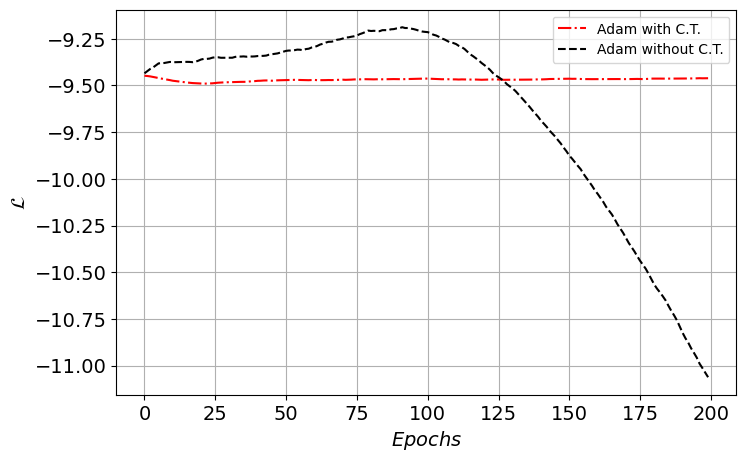

In [24]:
adam_ct_bw_200=np.loadtxt("DATA_c_txts/DATAc_200_likehood_adam_cd2_ct01_bw1.dat")
adam_bw_200=np.loadtxt("DATA_c_txts/DATAc_200_likehood_adam_cd201_bw.dat")
fig, axis = plt.subplots(1,1, figsize=(8,5))
axis.plot(adam_ct_bw_200, label="Adam with C.T.", color="red",  linestyle="dashdot")
axis.plot(adam_bw_200, label="Adam without C.T.", color="black",  linestyle="dashed")

axis.legend(fontsize="10")
axis.set_xlabel(r"$Epochs$")
axis.set_ylabel(r"$\mathcal{L}$")
axis.grid()



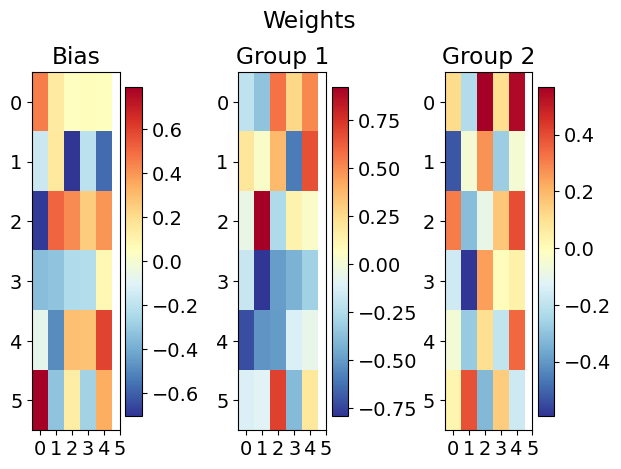

In [27]:
wvanillaCD1=np.loadtxt("DATA_c_txts/DATAc_200_w_adam_cd2_ct01_bw.dat")
avanillaCD1=np.loadtxt("DATA_c_txts/DATAc_200_a_adam_cd2_ct01_bw.dat")
heatmap_plot(avanillaCD1, wvanillaCD1)

### 7) Compute the log-likelihood L as a function of the epoch, or try one of the other quality indicators proposed in the paper by Decelle et al (drive), see especially the supplementary pdf. To compute the partition function (the hardest part in evaluating L), in our case one needs AG*2M~105 Boltzmann factors, which is doable.

Log-likelihood was implemented in Energy and probs section and it was used to see the accuracy of our models. At the end the best model we found was the Adam with CD=2 with centering trick and spins 0-1

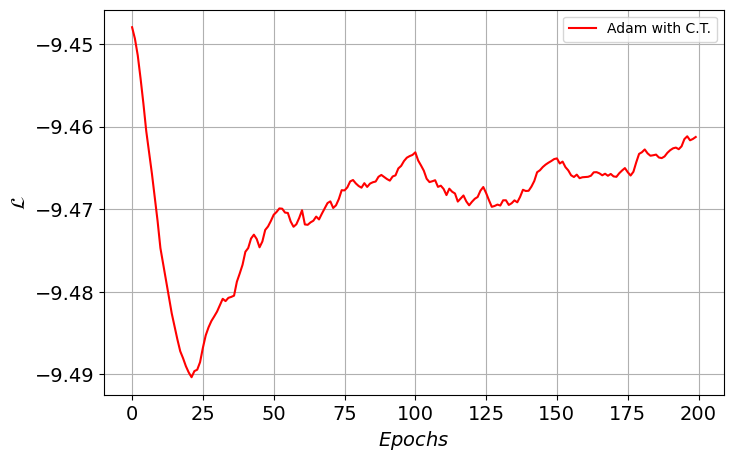

In [42]:
adam_ct_bw_200=np.loadtxt("DATA_c_txts/DATAc_200_likehood_adam_cd2_ct01_bw1.dat")
#adam_bw_200=np.loadtxt("DATA_c_txts/DATAc_200_likehood_adam_cd201_bw.dat")
fig, axis = plt.subplots(1,1, figsize=(8,5))
axis.plot(adam_ct_bw_200, label="Adam with C.T.", color="red",  linestyle="solid")
#axis.plot(adam_bw_200, label="Adam without C.T.", color="black",  linestyle="dashed")

axis.legend(fontsize="10")
axis.set_xlabel(r"$Epochs$")
axis.set_ylabel(r"$\mathcal{L}$")
#axis.set_title("Best configuration")
axis.grid()
